In [1]:
!git clone https://github.com/gbend22/Bioinformatics-Final-Assignment.git
import sys
sys.path.append('/content/Bioinformatics-Final-Assignment')

from google.colab import drive
drive.mount('/content/drive')

EXPR_PATH      = "/content/drive/MyDrive/tcga_RSEM_gene_fpkm.gz"
PHENOTYPE_PATH = "/content/drive/MyDrive/tcga_phenotype.tsv.gz"
PC_URL  = "https://raw.githubusercontent.com/CBIIT/TULIP/main/gene_lists/protein_coding_genes.txt"
PC_PATH = "/content/drive/MyDrive/protein_coding_genes.txt"

Cloning into 'Bioinformatics-Final-Assignment'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 7), reused 14 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.41 MiB | 15.16 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Mounted at /content/drive


In [2]:
from preprocessing import (
    load_protein_coding_genes,
    load_phenotype,
    load_expression_data,
    align_samples,
    filter_to_tulip_types,
    normalize_and_pad,
    encode_labels,
    split_data,
    create_dataloaders,
)
from models import LSTMClassifier

In [3]:
pc_gene_ids = load_protein_coding_genes(PC_URL, PC_PATH)
labels_full, primary_tumor_idx = load_phenotype(PHENOTYPE_PATH)
expr_full = load_expression_data(EXPR_PATH, pc_gene_ids, primary_tumor_idx)
expr, labels = align_samples(expr_full, labels_full, primary_tumor_idx)
del expr_full

Protein coding genes list already exists
Protein coding genes: 19,758
Total samples in phenotype file: 12804
Primary tumor samples: 10593
Expression matrix shape: (9185, 19740)
Genes matched: 19,740 / 19,758
Samples matched: 9,185 / 10,593
Aligned samples: 9185
Expression: (9185, 19740)
Labels: (9185, 3)


In [4]:
expr, y_raw, labels = filter_to_tulip_types(expr, labels)
X = normalize_and_pad(expr)
del expr

y, le, NUM_CLASSES = encode_labels(y_raw)
NUM_GENES = X.shape[1]

After filtering to 32 TULIP types: 9,185 samples, 32 classes
Value range after log10(TPM): [0.0000, 5.6057]
X shape: (9185, 19800)
NUM_CLASSES: 32


In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
del X

train_loader, val_loader, test_loader = create_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test
)

Train: (7348, 19800)
Val:   (918, 19800)
Test:  (919, 19800)


In [6]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

SEQ_LEN    = 198
INPUT_SIZE = NUM_GENES // SEQ_LEN
PROJ_DIM   = SEQ_LEN * INPUT_SIZE

model = LSTMClassifier(
    num_genes   = NUM_GENES,
    seq_len     = SEQ_LEN,
    input_size  = INPUT_SIZE,
    hidden_size = 128,
    num_layers  = 2,
    num_classes = NUM_CLASSES,
    dropout     = 0.3,
).to(device)

Using device: cuda


In [7]:
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

EPOCHS              = 60
EARLY_STOP_PATIENCE = 10

best_val_acc     = 0.0
patience_counter = 0
train_losses     = []
val_accs         = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out  = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds  = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
    val_acc = correct / total
    val_accs.append(val_acc)
    scheduler.step(1 - val_acc)

    print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_lstm.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

print(f"Best validation accuracy: {best_val_acc:.4f}")

Epoch   1 | Loss: 2.3330 | Val Acc: 0.7102
Epoch   2 | Loss: 0.8737 | Val Acc: 0.8660
Epoch   3 | Loss: 0.5310 | Val Acc: 0.8965
Epoch   4 | Loss: 0.4029 | Val Acc: 0.9107
Epoch   5 | Loss: 0.3414 | Val Acc: 0.9205
Epoch   6 | Loss: 0.2848 | Val Acc: 0.9194
Epoch   7 | Loss: 0.2635 | Val Acc: 0.9183
Epoch   8 | Loss: 0.2446 | Val Acc: 0.9303
Epoch   9 | Loss: 0.2348 | Val Acc: 0.9412
Epoch  10 | Loss: 0.2077 | Val Acc: 0.9216
Epoch  11 | Loss: 0.2072 | Val Acc: 0.9281
Epoch  12 | Loss: 0.1967 | Val Acc: 0.9227
Epoch  13 | Loss: 0.1834 | Val Acc: 0.9336
Epoch  14 | Loss: 0.1476 | Val Acc: 0.9434
Epoch  15 | Loss: 0.1354 | Val Acc: 0.9412
Epoch  16 | Loss: 0.1325 | Val Acc: 0.9401
Epoch  17 | Loss: 0.1213 | Val Acc: 0.9401
Epoch  18 | Loss: 0.1139 | Val Acc: 0.9379
Epoch  19 | Loss: 0.0967 | Val Acc: 0.9466
Epoch  20 | Loss: 0.0960 | Val Acc: 0.9466
Epoch  21 | Loss: 0.0919 | Val Acc: 0.9466
Epoch  22 | Loss: 0.0907 | Val Acc: 0.9434
Epoch  23 | Loss: 0.0845 | Val Acc: 0.9444
Epoch  24 |

In [8]:
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

model.load_state_dict(torch.load("best_lstm.pt"))
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

all_preds = np.array(all_preds)
all_true  = np.array(all_true)

test_acc = np.mean(all_preds == all_true)
print(f"Test Accuracy: {test_acc:.4f}")
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_, zero_division=0))

Test Accuracy: 0.9325
Classification Report:
                                       precision    recall  f1-score   support

                adrenocortical cancer       1.00      1.00      1.00         7
         bladder urothelial carcinoma       0.97      0.95      0.96        41
             brain lower grade glioma       0.98      0.94      0.96        51
            breast invasive carcinoma       1.00      0.99      1.00       109
       cervical & endocervical cancer       0.88      0.90      0.89        31
                   cholangiocarcinoma       0.50      0.67      0.57         3
                 colon adenocarcinoma       0.79      0.90      0.84        29
        diffuse large b-cell lymphoma       1.00      1.00      1.00         4
                 esophageal carcinoma       0.70      0.78      0.74        18
              glioblastoma multiforme       0.83      0.94      0.88        16
  head & neck squamous cell carcinoma       0.89      0.94      0.92        52
      

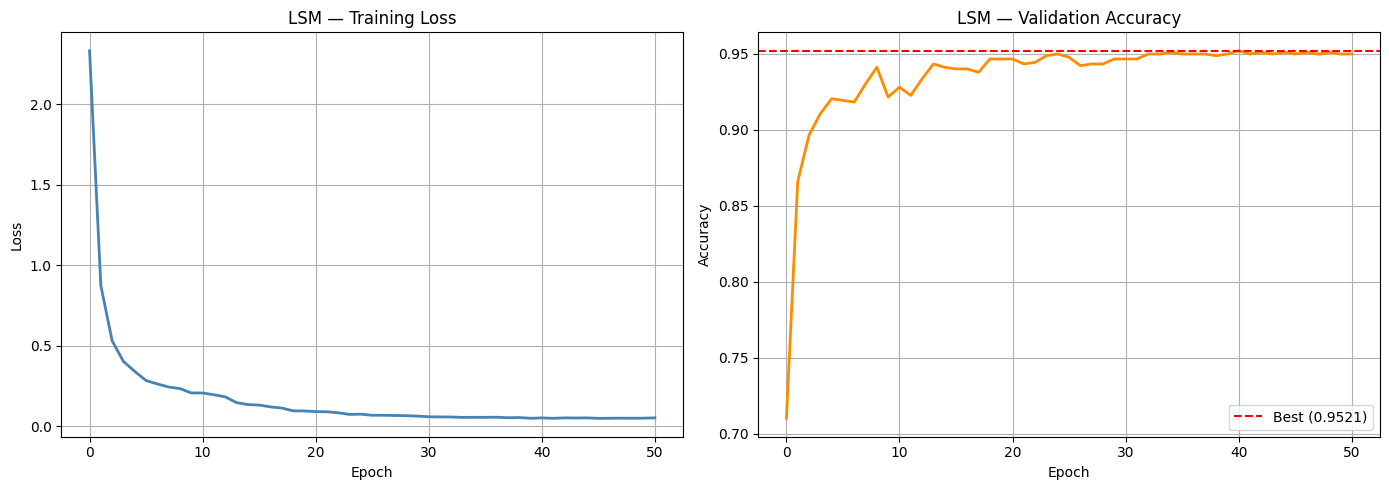

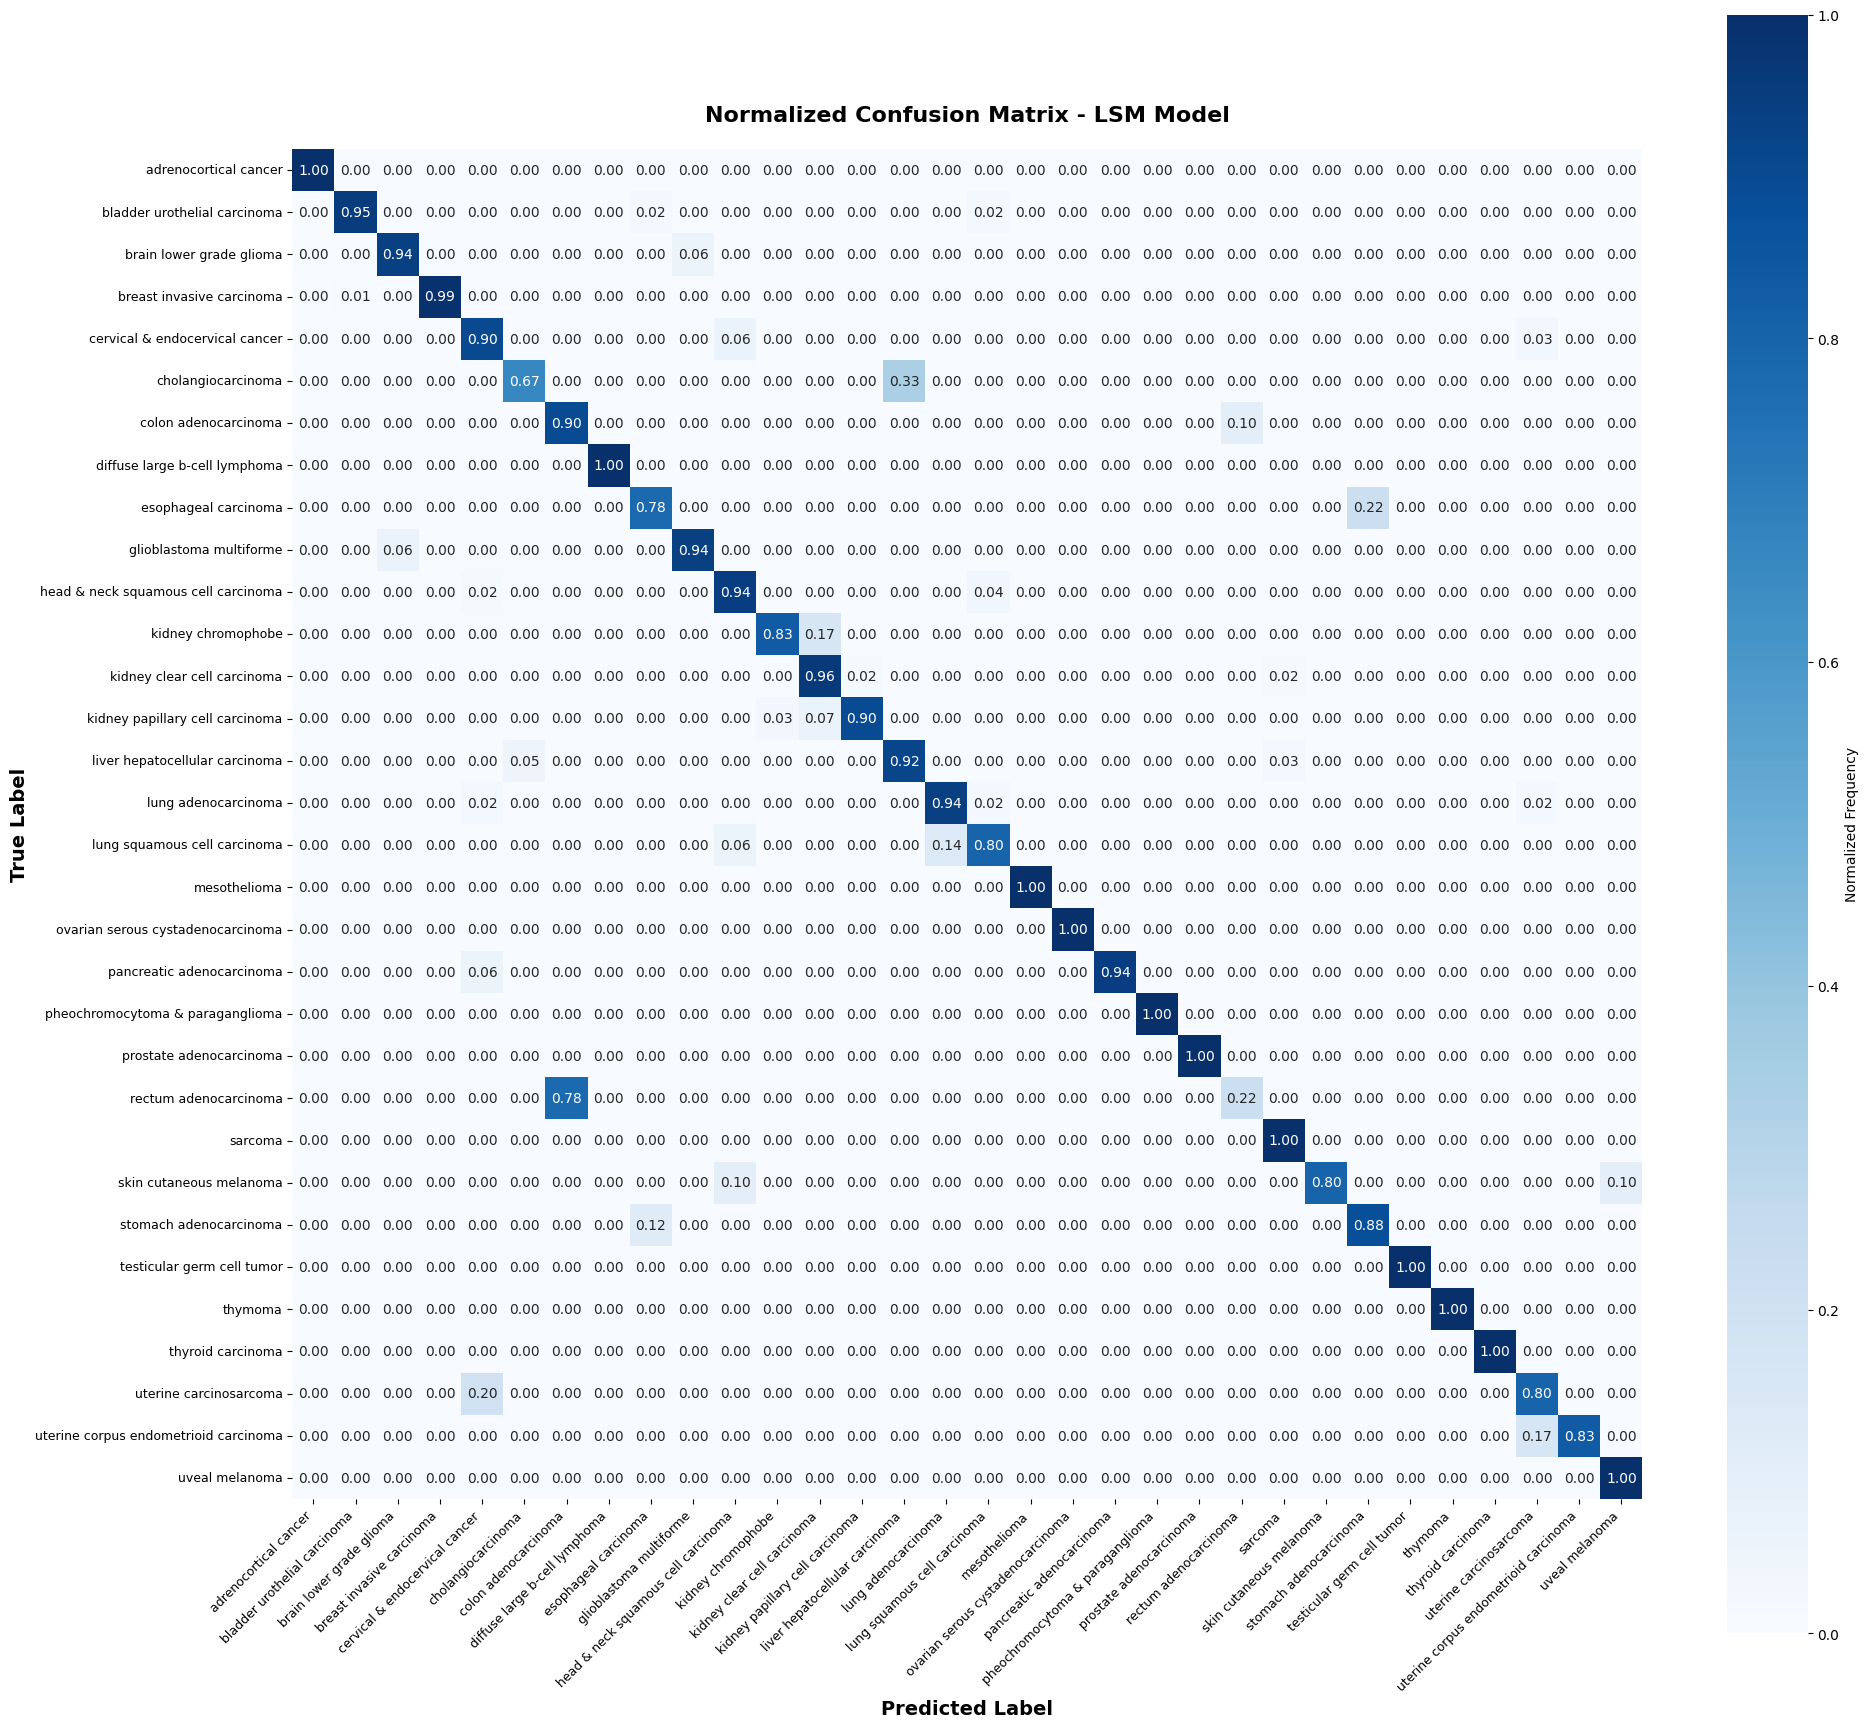

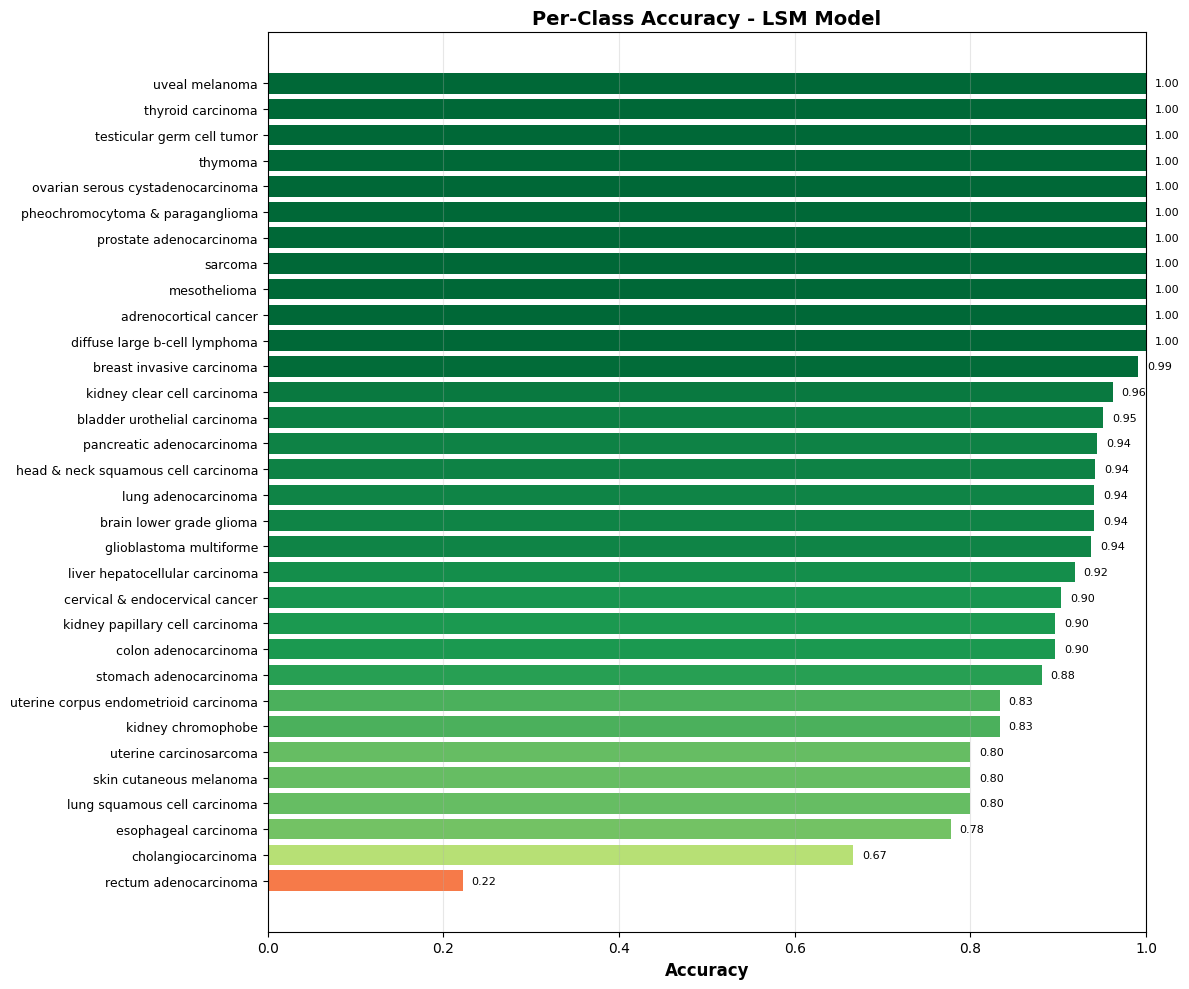

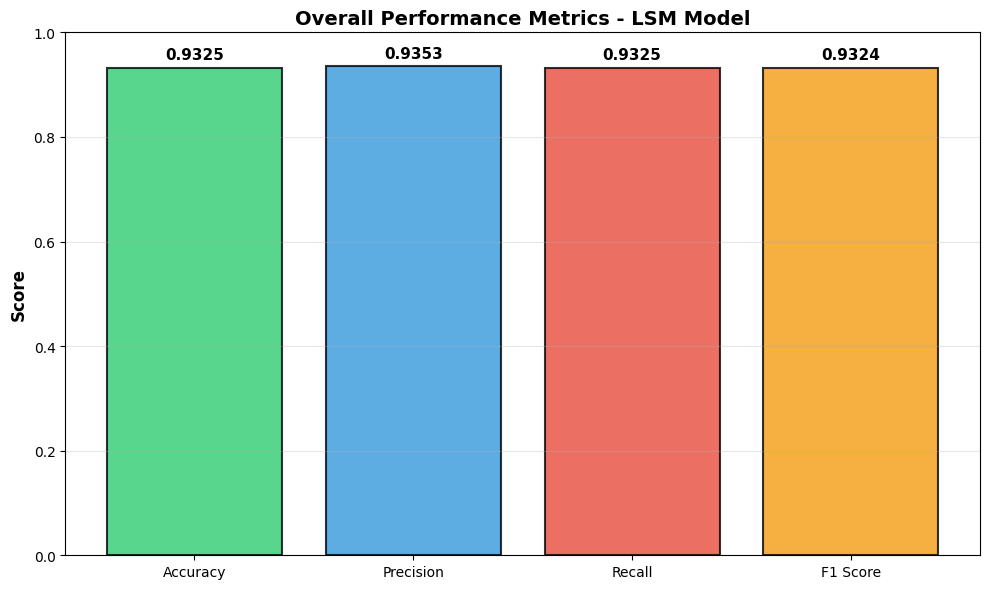

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, color="steelblue", linewidth=2)
axes[0].set_xlabel("Epoch");  axes[0].set_ylabel("Loss")
axes[0].set_title("LSM — Training Loss");  axes[0].grid(True)

axes[1].plot(val_accs, color="darkorange", linewidth=2)
axes[1].axhline(y=best_val_acc, color="red", linestyle="--",
                label=f"Best ({best_val_acc:.4f})")
axes[1].set_xlabel("Epoch");  axes[1].set_ylabel("Accuracy")
axes[1].set_title("LSM — Validation Accuracy")
axes[1].legend();  axes[1].grid(True)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/lsm_training_curves.png", dpi=150)
plt.show()

test_acc = np.mean(all_preds == all_true)
test_precision = precision_score(all_true, all_preds, average='weighted', zero_division=0)
test_recall = recall_score(all_true, all_preds, average='weighted', zero_division=0)
test_f1 = f1_score(all_true, all_preds, average='weighted', zero_division=0)

results = {
    'accuracy': test_acc,
    'precision': test_precision,
    'recall': test_recall,
    'f1_score': test_f1,
    'confusion_matrix': confusion_matrix(all_true, all_preds)
}

plt.figure(figsize=(20, 18))
class_names = le.classes_

cm_normalized = results['confusion_matrix'].astype('float') / results['confusion_matrix'].sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Normalized Frequency'},
    square=True
)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Normalized Confusion Matrix - LSM Model', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/lsm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

per_class_acc = cm_normalized.diagonal()
indices = np.argsort(per_class_acc)

plt.figure(figsize=(12, 10))
colors = plt.cm.RdYlGn(per_class_acc[indices])
bars = plt.barh(range(len(class_names)), per_class_acc[indices], color=colors)
plt.yticks(range(len(class_names)), class_names[indices], fontsize=9)
plt.xlabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Per-Class Accuracy - LSM Model', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)

for i, (bar, acc) in enumerate(zip(bars, per_class_acc[indices])):
    plt.text(acc + 0.01, i, f'{acc:.2f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/lsm_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [
    results['accuracy'],
    results['precision'],
    results['recall'],
    results['f1_score']
]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'],
               alpha=0.8, edgecolor='black', linewidth=1.5)
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Overall Performance Metrics - LSM Model', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/lsm_metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
import os

SAVE_DIR = "/content/drive/MyDrive/lstm_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

checkpoint = {
    "model_state_dict":     model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "best_val_acc":         best_val_acc,
    "test_acc":             float(test_acc),
    "train_losses":         train_losses,
    "val_accs":             val_accs,
    "hyperparams": {
        "NUM_GENES":    NUM_GENES,
        "PROJ_DIM":     PROJ_DIM,
        "SEQ_LEN":      SEQ_LEN,
        "INPUT_SIZE":   INPUT_SIZE,
        "hidden_size":  128,
        "num_layers":   2,
        "dropout":      0.3,
        "num_classes":  NUM_CLASSES,
    }
}
torch.save(checkpoint, os.path.join(SAVE_DIR, "best_lstm_checkpoint.pt"))

np.savez(
    os.path.join(SAVE_DIR, "shared_splits.npz"),
    X_train=X_train, X_val=X_val, X_test=X_test,
    y_train=y_train, y_val=y_val, y_test=y_test
)

np.save(os.path.join(SAVE_DIR, "label_classes.npy"), le.classes_)

lstm_results = {
    "test_acc":       float(test_acc),
    "best_val_acc":   float(best_val_acc),
    "train_losses":   np.array(train_losses),
    "val_accs":       np.array(val_accs),
    "all_preds":      all_preds,
    "all_true":       all_true,
    "precision":      precision,
    "recall":         recall,
    "f1":             f1,
    "classes":        le.classes_,
    "num_params":     sum(p.numel() for p in model.parameters()),
}
np.savez(os.path.join(SAVE_DIR, "lstm_results.npz"), **lstm_results)

print(f"LSTM Final Summary")
print(f"Best Val Accuracy :{best_val_acc:.4f}")
print(f"Test Accuracy:{test_acc:.4f}")
print(f"Macro F1:{f1.mean():.4f}")
print(f"Weighted F1:{np.average(f1, weights=[np.sum(all_true == i) for i in range(NUM_CLASSES)]):.4f}")
print(f"Parameters:{lstm_results['num_params']:,}")
print(f"Num Genes (input):{NUM_GENES}")
print(f"Num Classes:{NUM_CLASSES}")

LSTM Final Summary
Best Val Accuracy :0.9521
Test Accuracy:0.9325
Macro F1:0.8935
Weighted F1:0.9324
Parameters:639,520
Num Genes (input):19800
Num Classes:32
